## Catalog .box() API


This notebook demonstrates the new box API on LSDB catalogs to filter pixels by:

- __(1)__ Right ascension band: `catalog.box(ra=(theta1,theta2))`

- __(2)__ Declination band: `catalog.box(dec=(theta1,theta2))`

- __(3)__ Both right ascension and declination: `catalog.box(ra=(theta1,theta_2),dec=(theta1,theta_2))`

The current implementation consists of two stages:

- __(Coarse and lazy)__: filtering the catalog HEALpix to obtain those that overlap with the region

- __(Fine)__: filtering the points inside each HEALPix to get those that are inside of the region

In [1]:
import lsdb
import hipscat as hc

### Helper methods to plot filters and catalog pixel maps

In [2]:
import healpy as hp
import numpy as np
from hipscat.inspection import plot_pixels
from hipscat.pixel_math import HealpixPixel

def plot_catalog_pixel_map(hc_catalog):
    order = hc_catalog.pixel_tree.get_max_depth()
    order_map = construct_pixel_map(hc_catalog.get_healpix_pixels(), order)
    plot_pixel_map(order_map, f"{hc_catalog.catalog_info.catalog_name} pixel map")
    
def plot_ra_filter(ra_range, order):
    pixel_tree = hc.pixel_math.box_filter._generate_ra_strip_pixel_tree(ra_range, order)
    pixels_in_range = [HealpixPixel(order, p) for p in pixel_tree.pixels[order]]
    order_map = construct_pixel_map(pixels_in_range, order)
    plot_pixel_map(order_map, f"Filter for ra {ra_range[0]} to {ra_range[1]}")

def plot_dec_filter(dec_range, order):
    pixel_tree = hc.pixel_math.box_filter._generate_dec_strip_pixel_tree(dec_range, order)
    pixels_in_range = [HealpixPixel(order, p) for p in pixel_tree.pixels[order]]
    order_map = construct_pixel_map(pixels_in_range, order)
    plot_pixel_map(order_map, f"Filter for dec {dec_range[0]} to {dec_range[1]}")
    
def plot_pixel_map(order_map, title=""):
    hp.newvisufunc.projview(
        order_map, 
        projection_type="mollweide", 
        graticule=True, 
        graticule_labels=True,
        xlabel="ra",
        ylabel="dec",
        nest=True,
        title=title
    )

def construct_pixel_map(pixels, max_order):
    order_map = np.full(hp.order2npix(max_order), hp.pixelfunc.UNSEEN)
    for pixel in pixels:
        explosion_factor = 4 ** (max_order - pixel.order)
        exploded_pixels = [
            *range(
                pixel.pixel * explosion_factor,
                (pixel.pixel + 1) * explosion_factor,
            )
        ]
        order_map[exploded_pixels] = pixel.order
    return order_map

### Importing a catalog

Let's import a catalog using `read_hipscat` and visualize its pixel distribution:

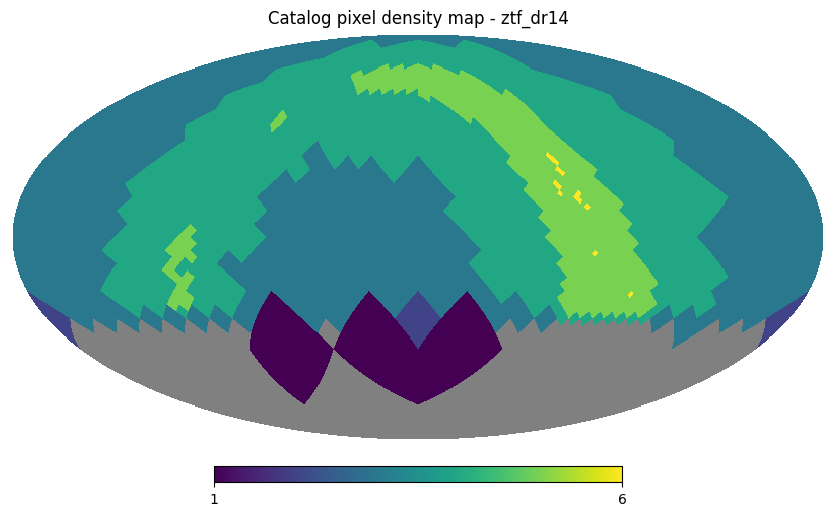

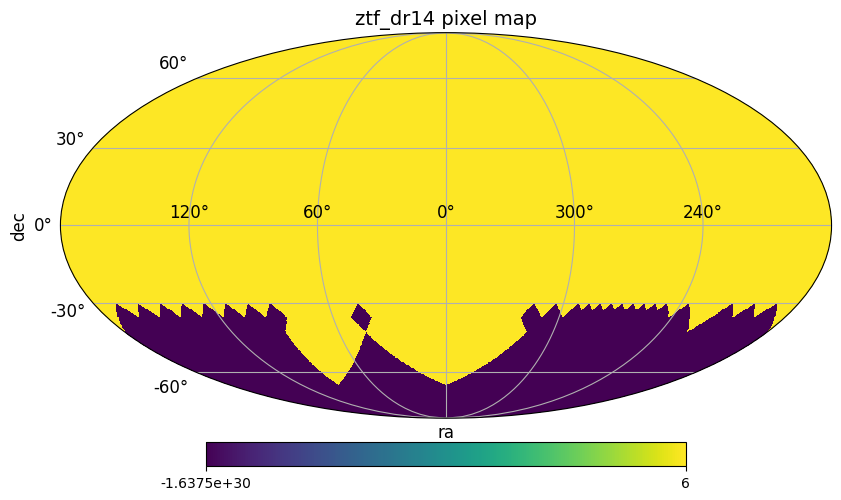

In [3]:
ztf_dr14 = lsdb.read_hipscat("epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

ztf_dr14_order = ztf_dr14.hc_structure.pixel_tree.get_max_depth()

plot_pixels(ztf_dr14.hc_structure)
plot_catalog_pixel_map(ztf_dr14.hc_structure)

### Search by right ascension

Search by points in the RA band. Let's also look at the filter created and the results obtained.

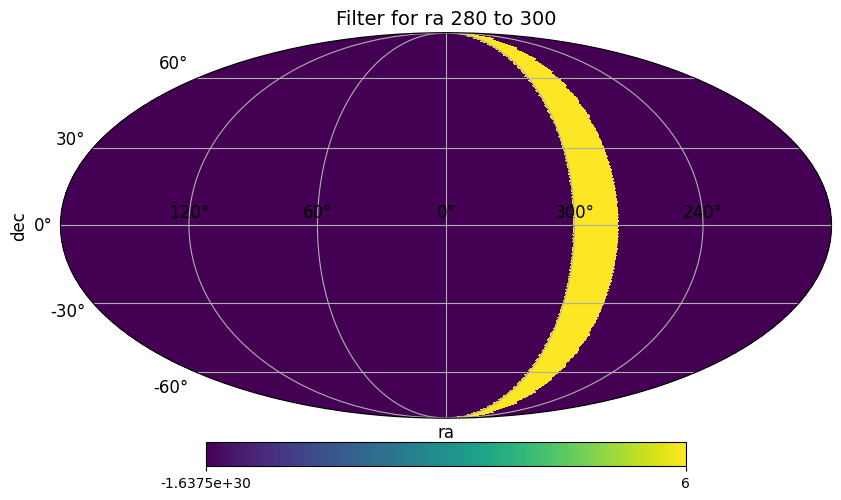

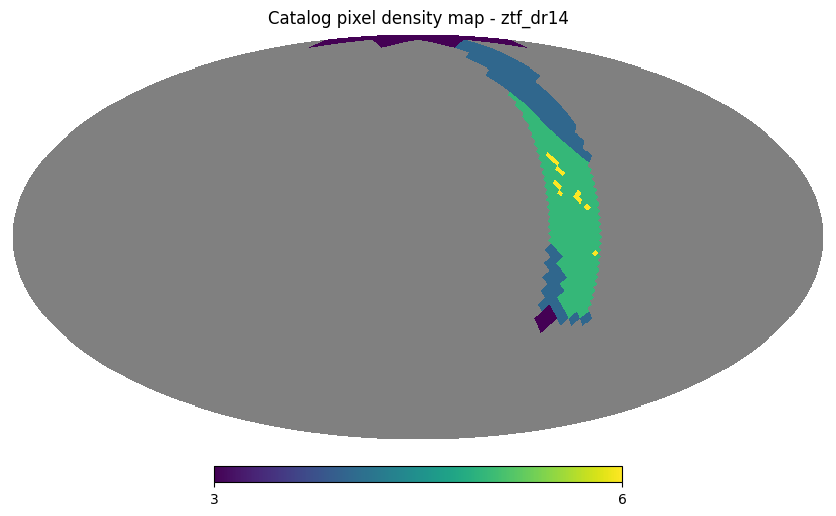

In [4]:
ra_search_catalog = ztf_dr14.box(ra=(280, 300))
plot_ra_filter((280, 300), ztf_dr14_order)
plot_pixels(ra_search_catalog.hc_structure)

In [5]:
ra_search_catalog._ddf.partitions[0].compute()

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,


### Search by declination

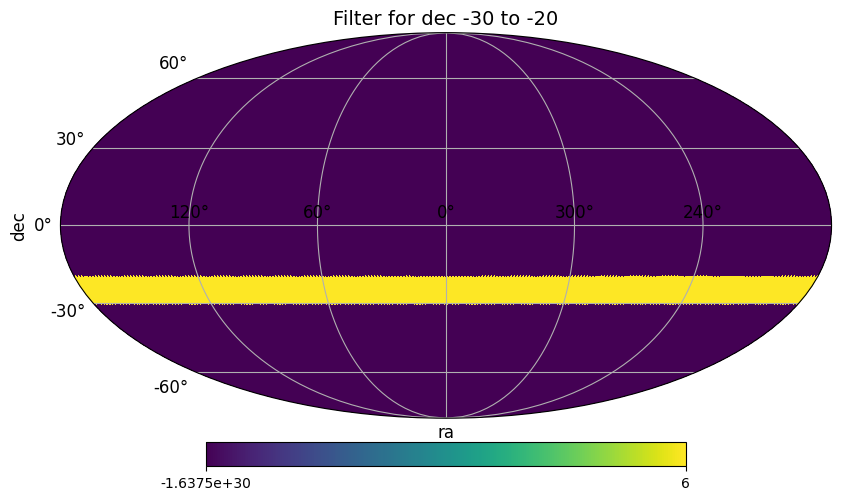

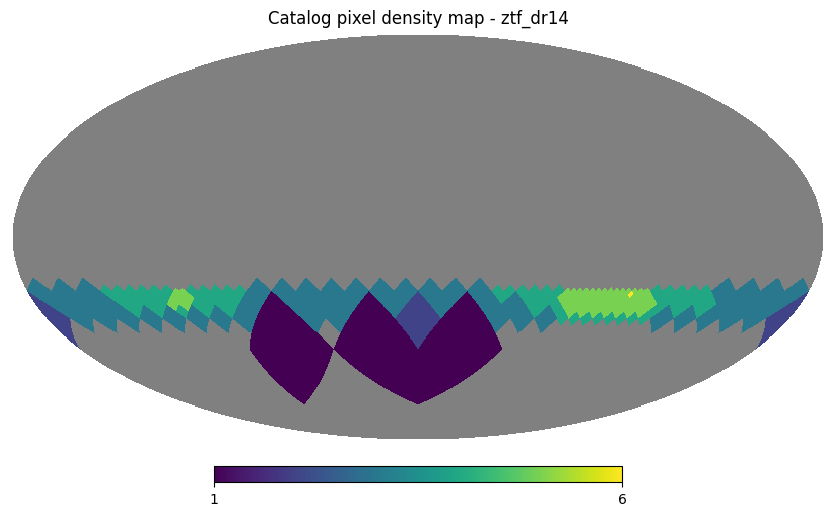

In [6]:
dec_search_catalog = ztf_dr14.box(dec=(-30, -20))
plot_dec_filter((-30, -20), ztf_dr14_order)
plot_pixels(dec_search_catalog.hc_structure)

In [7]:
dec_search_catalog._ddf.partitions[0].compute()

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,
4635794597459525632,72010100523102432,10.052400,-29.989982,19.684500,18.413601,17.456400,3,6,0,19.586278,18.371036,NaN,2,0,64
4635794779207106560,72010100559642388,10.056168,-29.989900,17.551201,16.436899,15.851700,10,7,0,17.607505,16.419077,NaN,2,0,64
4635797697691910144,72000100003277993,10.000391,-29.993617,20.462200,19.276800,18.325399,2,4,0,20.670395,19.173893,NaN,2,0,64
4635797711239512064,72010100036352351,10.003612,-29.989958,21.498501,20.552099,19.635700,0,2,0,NaN,19.981890,NaN,2,0,64
4635797980551577600,72010099514710056,9.951483,-29.991913,-999.000000,21.101999,20.599899,0,1,0,NaN,19.813833,NaN,2,0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4683682217182887936,83993598996612108,359.899719,-20.006807,-999.000000,21.936701,21.960699,0,2,0,NaN,21.123683,NaN,2,0,64
4683682222610317312,83993598913272488,359.891403,-20.006422,22.183701,-999.000000,20.544901,0,52,0,NaN,20.778792,NaN,2,0,64
4683682222610317313,83993598915492804,359.891403,-20.006422,-999.000000,21.358700,20.803200,0,52,0,NaN,20.778792,NaN,2,0,64


### Search by box of right ascension and declination

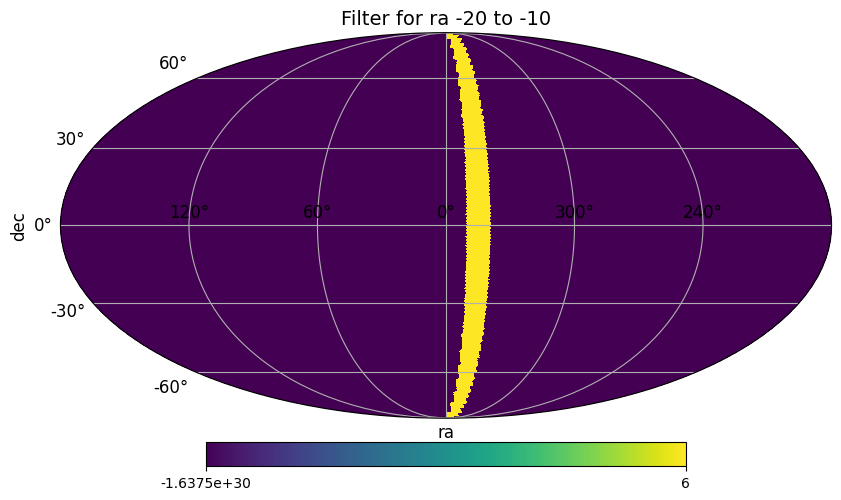

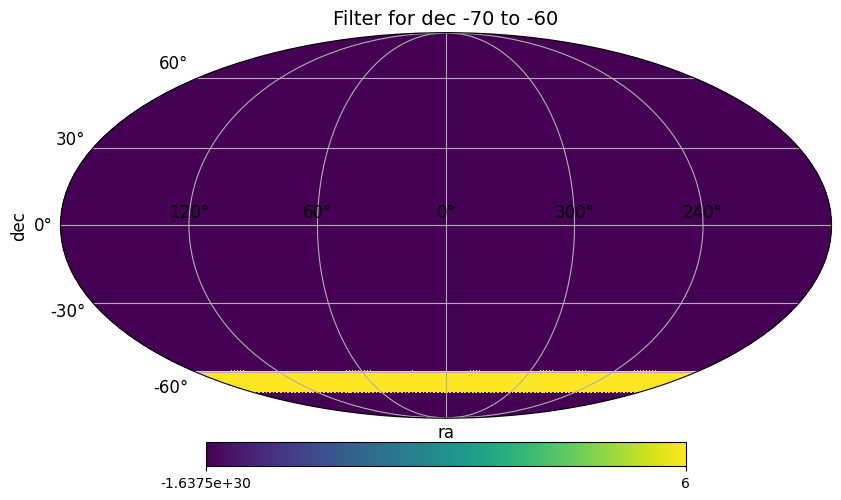

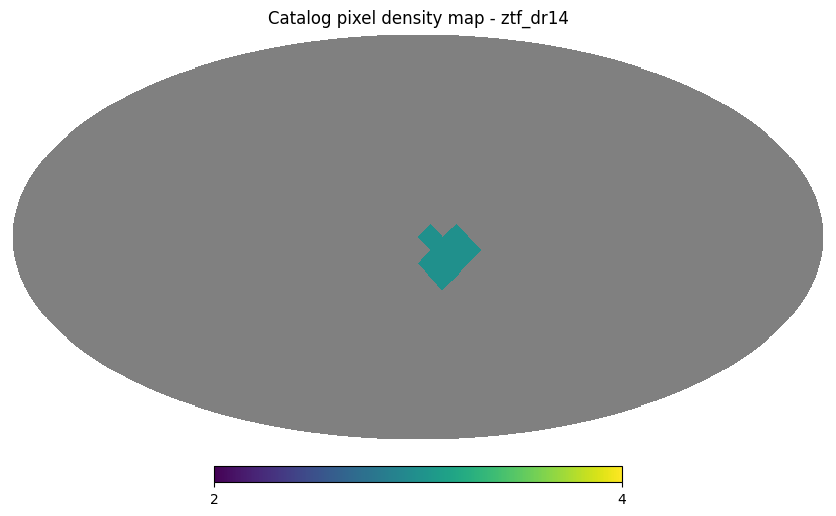

In [25]:
box_search_catalog = ztf_dr14.box(ra=(-20, -10), dec=(-10, 0))
plot_ra_filter((-20, -10), ztf_dr14_order)
plot_dec_filter((-10, 0), ztf_dr14_order)
plot_pixels(box_search_catalog.hc_structure)

In [26]:
box_search_catalog._ddf.partitions[0].compute()

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,
4827708680562540544,96003492180212564,349.217987,-9.998227,-999.000000,21.345900,20.726900,0,4,0,NaN,20.574177,NaN,3,0,267
4827709118259134464,96013492042106003,349.203918,-9.987175,21.770599,21.373199,20.601500,1,7,0,21.014761,20.286653,NaN,3,0,267
4827709118259134465,96013492038865842,349.203918,-9.987175,21.571699,20.925501,20.401899,1,7,0,21.014761,20.286653,NaN,3,0,267
4827709226207936512,96023491907721053,349.190826,-9.982803,21.783001,21.002899,20.311800,1,11,0,21.407619,20.377385,NaN,3,0,267
4827709260190187520,96023491873587731,349.187241,-9.977174,21.687300,21.242500,20.946800,1,5,0,21.127998,20.667318,NaN,3,0,267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4827858689564082176,96463487410593492,348.741016,-9.614140,21.765301,21.163700,20.809900,14,85,14,21.287239,20.766812,20.325354,3,0,267
4827858694500777984,96463487458437712,348.745834,-9.610734,-999.000000,-999.000000,21.687500,0,1,1,NaN,21.768810,21.014776,3,0,267
4827858722011217920,96473487407381414,348.740774,-9.607514,-999.000000,21.735500,21.534800,0,6,2,NaN,21.106965,20.159413,3,0,267


### Additional insights

There are lots of important edge cases covered by unit tests. Keep in mind that we are including all the pixels that overlap with the region, which means we may get pixels that partially fall outside of it.

- The ranges should not coincide (e.g. `[0,0]` or `[50,50]` should not be valid, for both RA and DEC)

- The declination range must be provided in ascending order

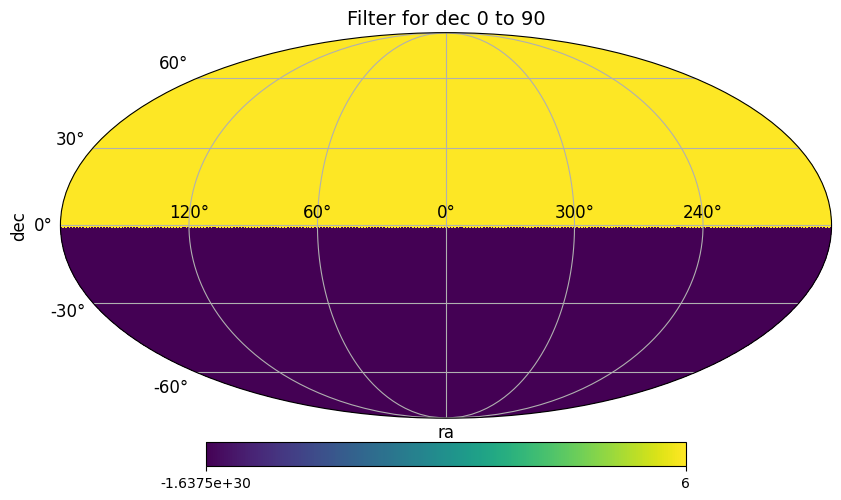

In [10]:
# To get the whole of the north hemisphere
plot_dec_filter((0, 90), ztf_dr14_order)

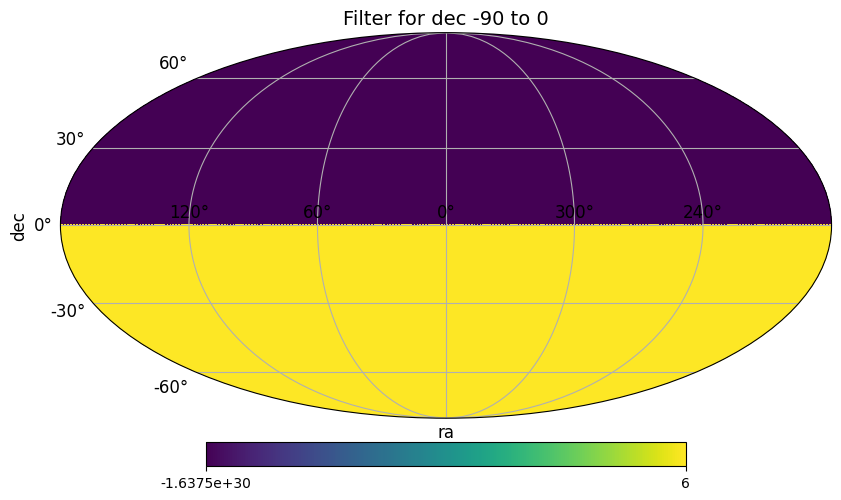

In [11]:
# To get the whole of the north and south hemisphere
plot_dec_filter((-90, 0), ztf_dr14_order)

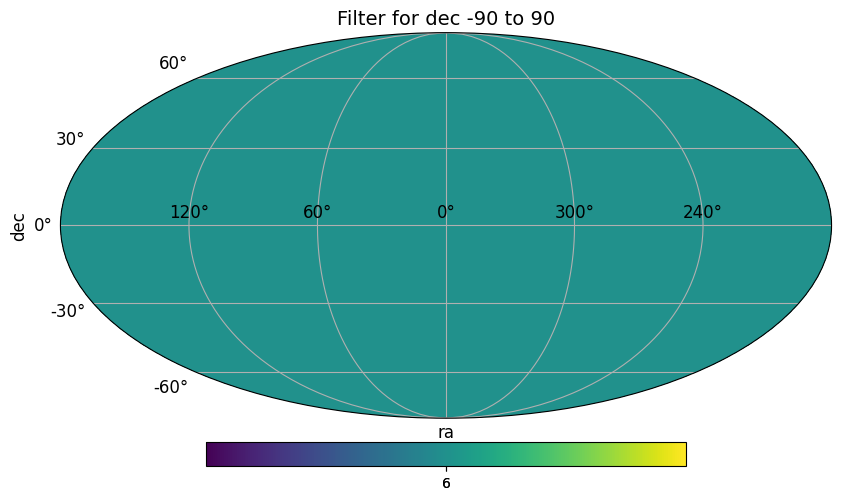

In [12]:
# To get the whole of the north and south hemisphere
plot_dec_filter((-90, 90), ztf_dr14_order)

- It's crucial to consider the angle order of the RA ranges because they yield "complementary" polygons

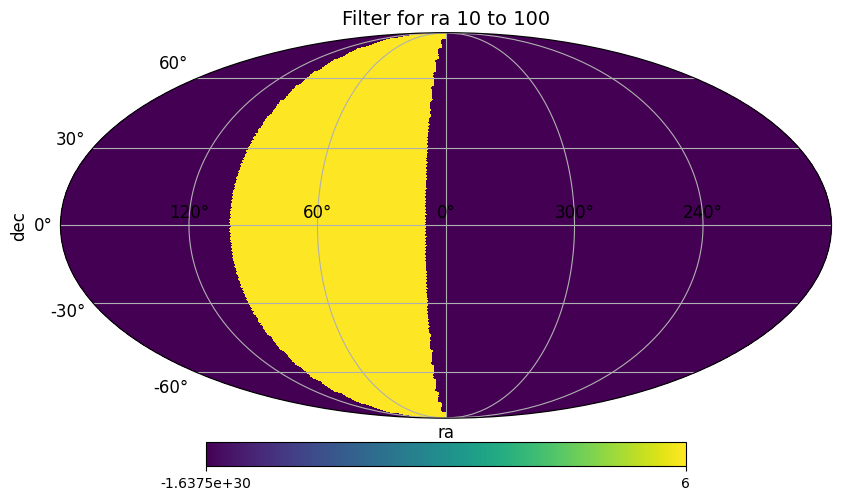

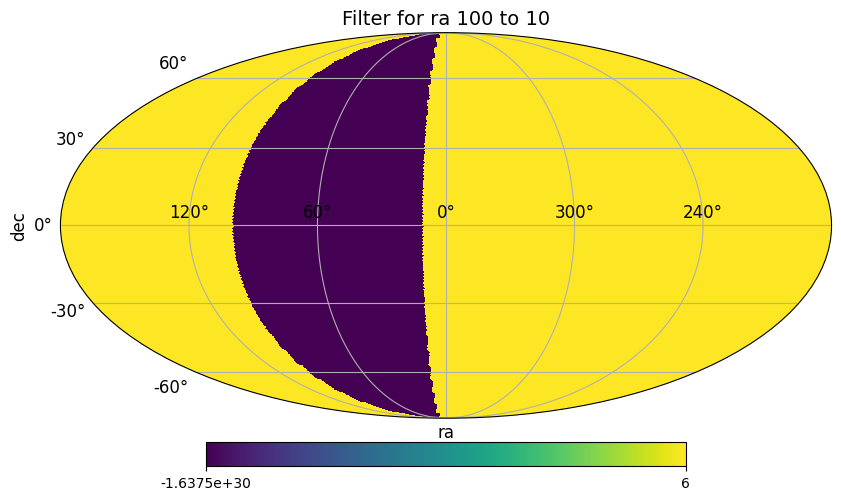

In [13]:
# While [10,50] yields a small polygon of 40 degrees, [50,10] should yield a polygon of 320 degrees
plot_ra_filter((10, 100), ztf_dr14_order)
plot_ra_filter((100, 10), ztf_dr14_order)

In fact, whenever right ascensions are >= 180 we should consider the wider polygon:

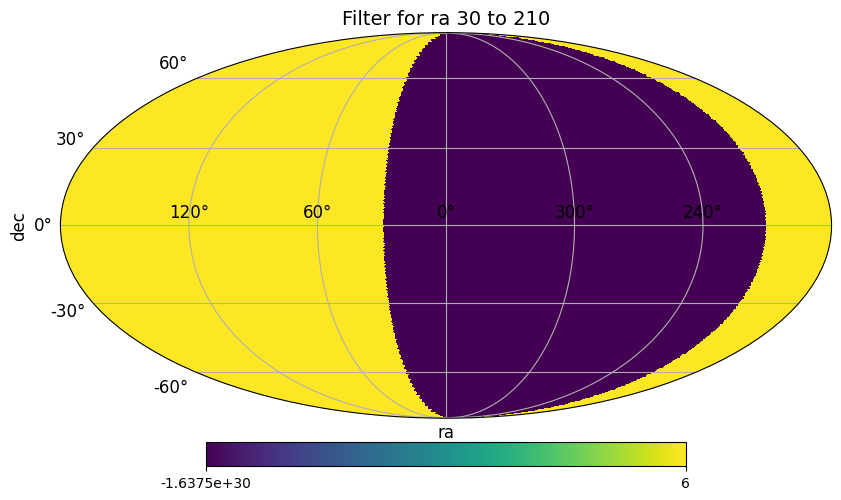

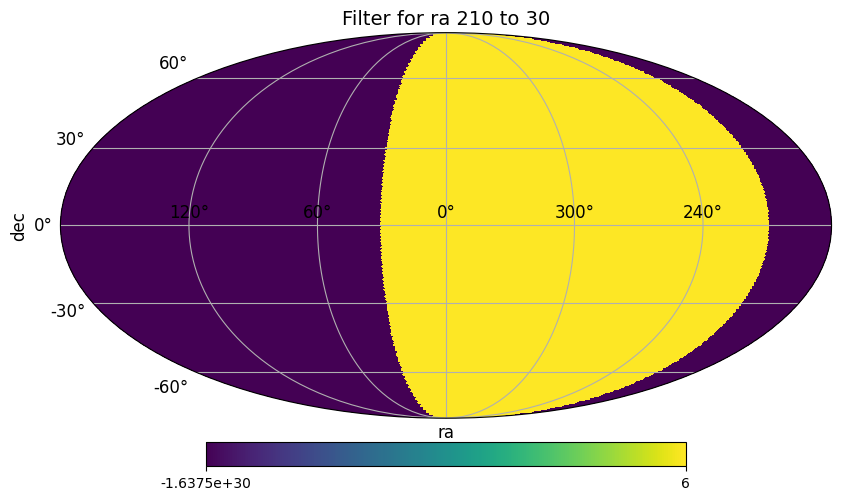

In [14]:
plot_ra_filter((30, 210), ztf_dr14_order)
plot_ra_filter((210, 30), ztf_dr14_order)

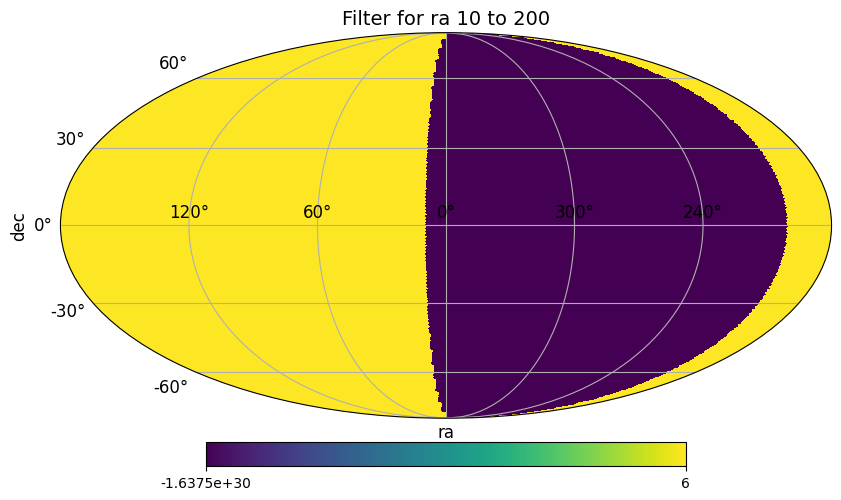

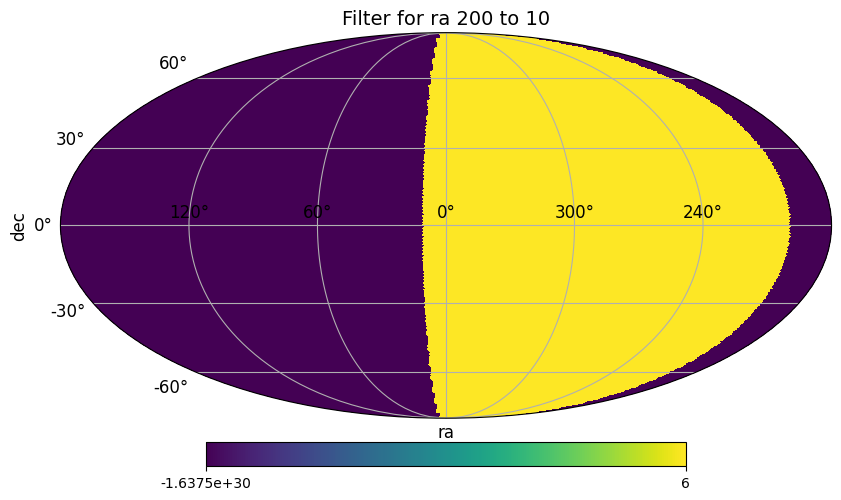

In [15]:
plot_ra_filter((10, 200), ztf_dr14_order)
plot_ra_filter((200, 10), ztf_dr14_order)

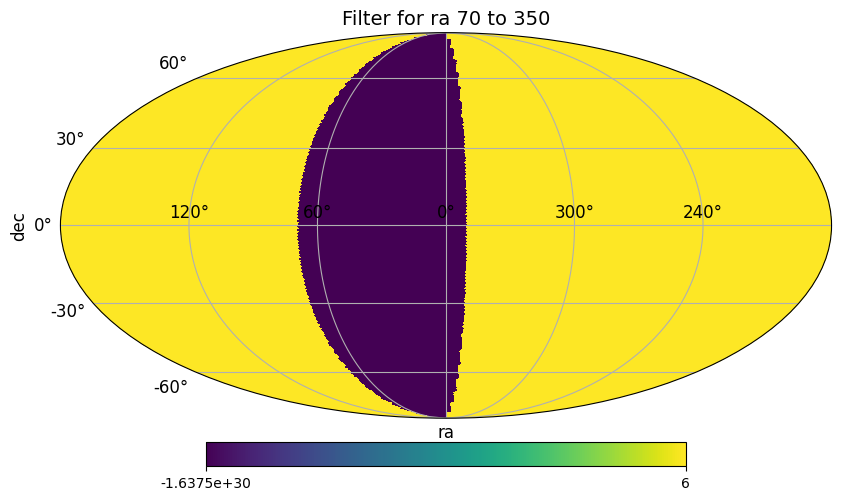

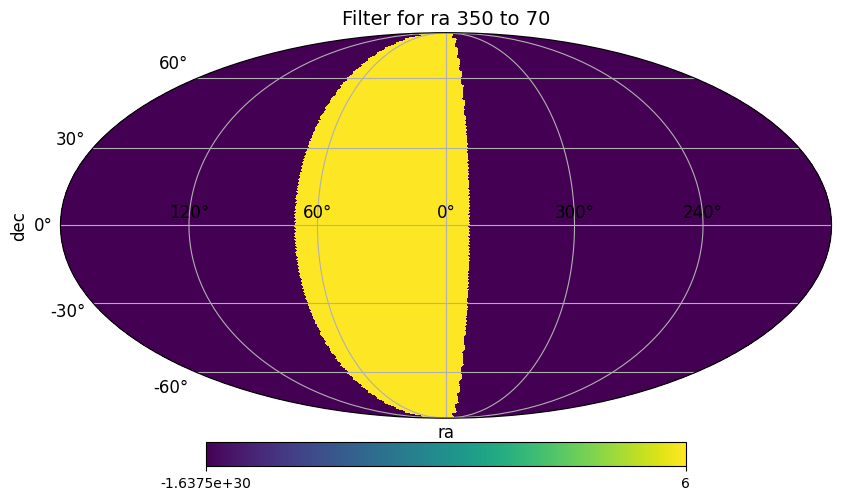

In [16]:
plot_ra_filter((70, 350), ztf_dr14_order)
plot_ra_filter((350, 70), ztf_dr14_order)